# 日経平均ブル２倍 日足

In [11]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '1579.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='3mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-07-01 00:00:00+09:00,3.174000,3.193000,3.127000,3.136000,2029290000,0.0,0.0,0.0
2024-07-02 00:00:00+09:00,312.700012,322.000000,311.399994,321.200012,24218920,0.0,0.0,0.0
2024-07-03 00:00:00+09:00,323.399994,331.399994,322.700012,329.799988,26989140,0.0,0.0,0.0
2024-07-04 00:00:00+09:00,331.799988,335.700012,329.700012,334.799988,27283890,0.0,0.0,0.0
2024-07-05 00:00:00+09:00,335.700012,338.000000,332.100006,334.299988,25627130,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-09-24 00:00:00+09:00,278.799988,281.200012,273.500000,273.700012,37045440,0.0,0.0,0.0
2024-09-25 00:00:00+09:00,273.700012,276.399994,272.700012,272.700012,24141230,0.0,0.0,0.0
2024-09-26 00:00:00+09:00,280.000000,287.600006,279.899994,286.200012,40364900,0.0,0.0,0.0


## パラボリック SAR

In [12]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

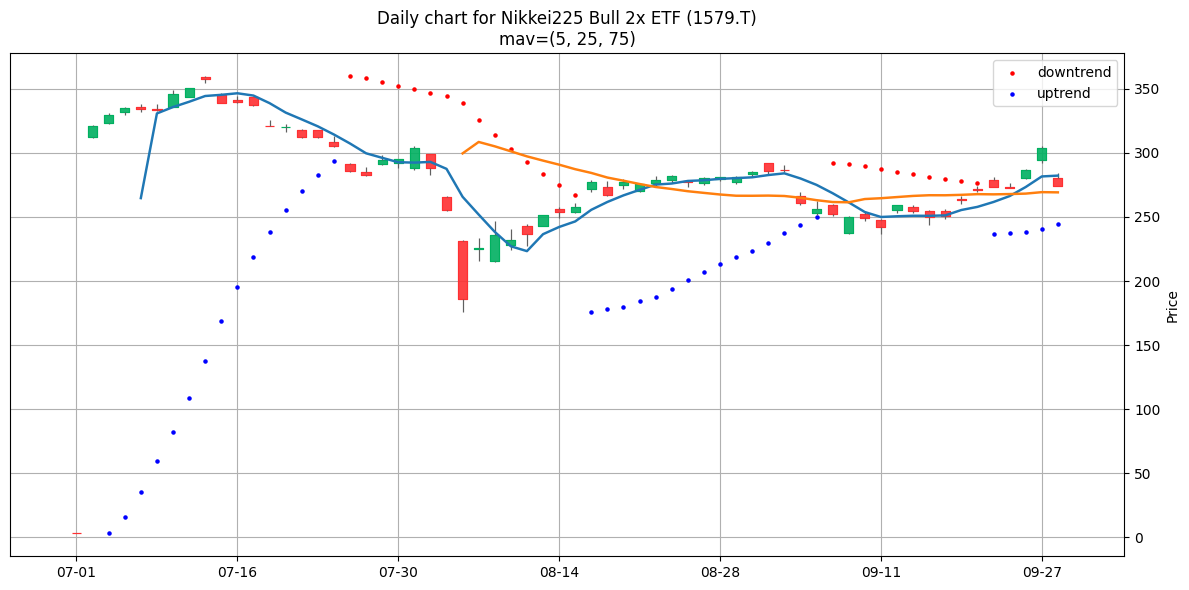

In [13]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='yahoo',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_1579.png')
plt.show()

In [14]:
df.tail(2)['Close']

Date
2024-09-27 00:00:00+09:00    304.100006
2024-09-30 00:00:00+09:00    274.299988
Name: Close, dtype: float64

In [15]:
df.tail(2)['Close'].diff()

Date
2024-09-27 00:00:00+09:00          NaN
2024-09-30 00:00:00+09:00   -29.800018
Name: Close, dtype: float64